In [5]:
# Importing everything for Time Series

import matplotlib.pyplot as plt  # plots
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import seaborn as sns  # more plots

sns.set()

import warnings  
from itertools import product  # some useful functions

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
from dateutil.relativedelta import \
    relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
from tqdm.notebook import tqdm
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore") # `do not disturbe` mode

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
df = pd.read_csv("orders.csv")
df

,created_at_utc,tariff_class,tariff_internal_name,status,taxi_status,vehicle_model,vehicle_color,vehicle_car_region,payment_cost,payment_currency_code,driver_call_model
0,1622145491,Эконом,econom,cancelled,waiting,Kia Rio,белый,34,52.00,RUB,no_call
1,1622145422,Эконом,econom,cancelled,driving,LADA (ВАЗ) Granta,серый,34,0.00,RUB,no_call
2,1622145212,Эконом,econom,finished,complete,Renault Logan,белый,34,104.70,RUB,on_demand
3,1622054615,Эконом,econom,finished,complete,LADA (ВАЗ) Granta,белый,34,120.00,RUB,on_demand
4,1622045036,Эконом,econom,finished,complete,LADA (ВАЗ) Granta,белый,34,115.50,RUB,on_demand
...,...,...,...,...,...,...,...,...,...,...,...
1200,1617028952,Эконом,econom,finished,complete,LADA (ВАЗ) Largus,белый,34,472.40,RUB,no_call
1201,1617028458,Эконом,econom,cancelled,driving,LADA (ВАЗ) Granta,белый,34,0.00,RUB,no_call
1202,1617025078,Эконом,econom,finished,complete,LADA (ВАЗ) Granta,серый,34,146.85,RUB,no_call
1203,1616869125,Эконом,econom,cancelled,driving,LADA (ВАЗ) Largus,серый,34,0.00,RUB,no_call


In [7]:
df = df.loc[df['payment_cost']!=0]
df = df.dropna()

**For our time series we only have one target - payment_cost. We will work with this in the begining along with tariff class.**

In [ ]:
import pandas as pd

# Assuming 'data' is your DataFrame or Series with a non-datetime index
# Convert the index to datetime if it's not already
data.index = pd.to_datetime(data.index)

# Ensure the index is sorted
data = data.sort_index()

# Extend the index to include future time periods
# Specify the number of periods you want to forecast into
forecast_periods = 10  # Example number of forecast periods
extended_index = pd.date_range(start=data.index.min(), periods=len(data) + forecast_periods, freq='M')

# Assign the extended index back to the data
data = data.reindex(extended_index)

# Now your data index is prepared for forecasting


In [8]:
#Converting to date-time
df = df[['created_at_utc','payment_cost']]
df['created_at_utc'] = pd.to_datetime(df.created_at_utc, unit='s')
df['created_at_utc'] = df['created_at_utc'].dt.date
df = df.groupby('created_at_utc').payment_cost.mean()
df = df.reset_index()
df.sort_values(by=['created_at_utc'], inplace=True)
df.set_index('created_at_utc', inplace=True)

df

,payment_cost
created_at_utc,
2017-09-30,78.775000
2017-10-18,438.150000
2017-10-19,425.500000
2017-10-27,98.325000
2017-11-02,96.025000
...,...
2021-05-23,555.225000
2021-05-24,83.525000
2021-05-25,435.683333


In [39]:
df = df.tail(100)
df

,payment_cost
created_at_utc,
2021-01-26,115.000000
2021-01-27,316.666667
2021-01-28,285.000000
2021-01-29,328.000000
2021-01-30,393.333333
...,...
2021-05-23,555.225000
2021-05-24,83.525000
2021-05-25,435.683333


In [36]:
import pandas as pd

# Assuming 'data' is your DataFrame with a datetime index covering the period from 2017 to 2021
# Ensure the index is in datetime format

data= df.copy()

data.index = pd.to_datetime(data.index)

# Ensure the index is sorted
data = data.sort_index()

# Extend the index to include future time periods (3 years)
forecast_years = 3  # Forecasting for 3 years
extended_index = pd.date_range(start=data.index.max(), periods=forecast_years*12 + 1, freq='M')[1:]

# Assign the extended index back to the data
data = data.reindex(data.index.union(extended_index))

# Now your data index is extended for forecasting until 2024


In [37]:
data

,payment_cost
2017-09-30,78.775
2017-10-18,438.150
2017-10-19,425.500
2017-10-27,98.325
2017-11-02,96.025
...,...
2024-01-31,NaN
2024-02-29,NaN
2024-03-31,NaN
2024-04-30,NaN


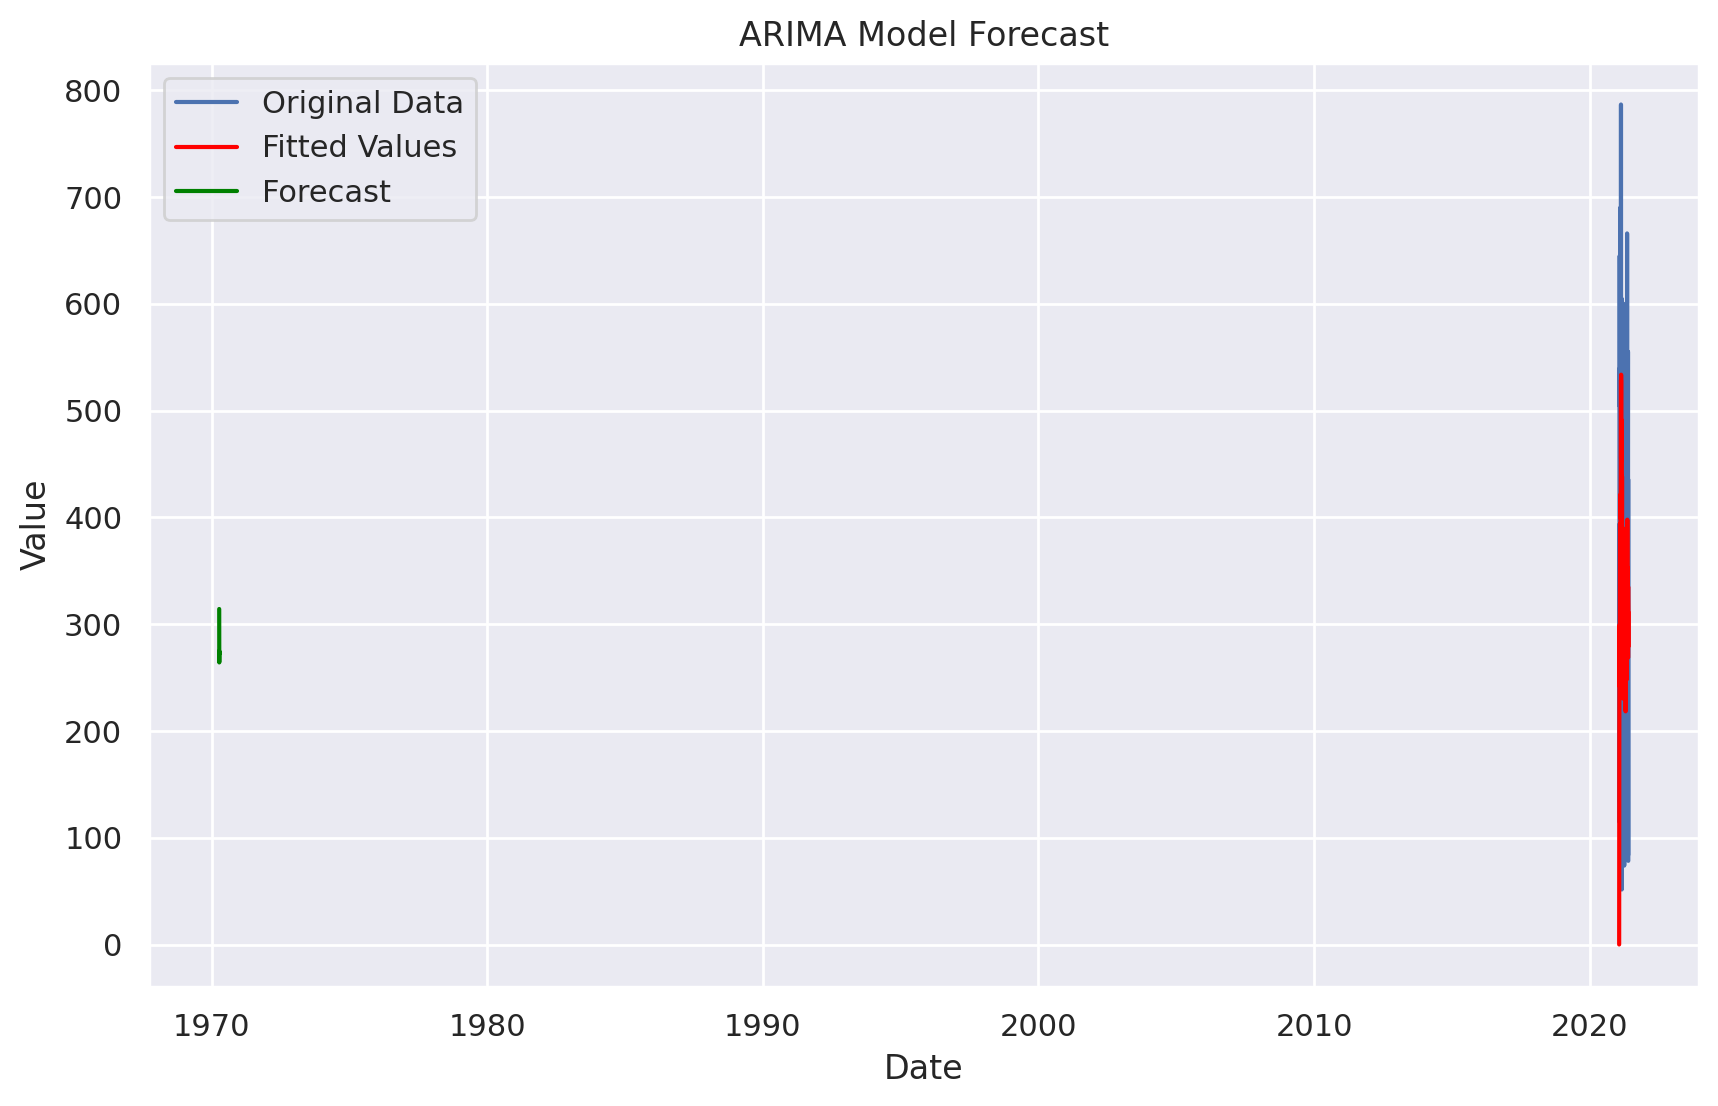

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load your time series data
# Assuming you have a pandas DataFrame with a 'date' index and a 'value' column
# Replace 'your_data.csv' with your actual data file

data = df.copy()
# Fit the ARIMA model
# Specify the appropriate (p, d, q) parameters
# Replace p, d, q with your chosen values
p, d, q = (1, 1, 1)  # Example parameters
model = ARIMA(data, order=(p, d, q))
fitted_model = model.fit()

# Forecast future values
# Specify the number of steps you want to forecast
# Replace steps with the number of steps you want to forecast
steps = 10  # Example steps
forecast = fitted_model.forecast(steps=steps)

# Plot the original data, fitted values, and forecasts
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original Data')
plt.plot(fitted_model.fittedvalues, color='red', label='Fitted Values')
plt.plot(forecast, color='green', label='Forecast')
plt.legend()
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


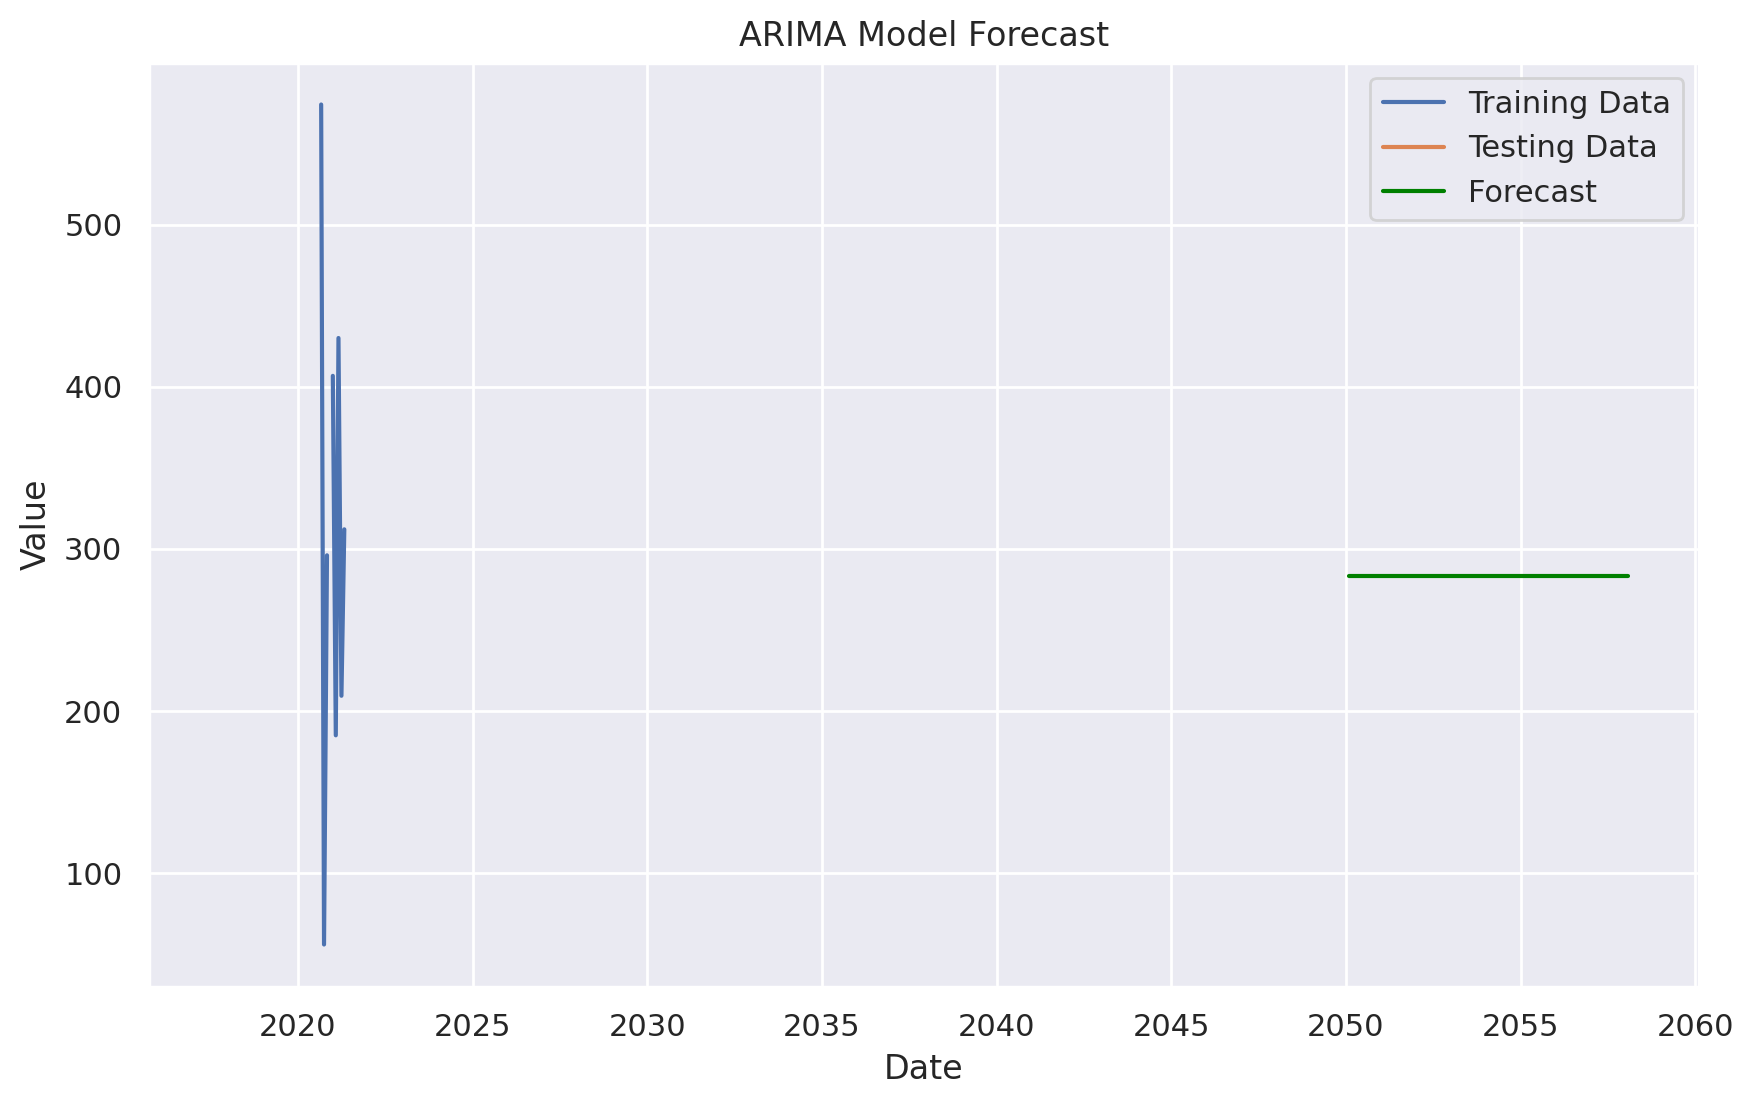

ValueError: Input contains NaN.

In [9]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)  # Use 80% of data for training
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Fit the ARIMA model
p, d, q = (1, 1, 1)  # Example parameters
model = ARIMA(train, order=(p, d, q))
fitted_model = model.fit()

# Forecast future values
steps = len(test)  # Forecast for the length of the test set
forecast = fitted_model.forecast(steps=steps)

# Plot the original data and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(test.index, forecast, color='green', label='Forecast')
plt.legend()
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Evaluate the forecast
mse = mean_squared_error(test, forecast)
print('Mean Squared Error:', mse)

<Figure size 1000x600 with 0 Axes>

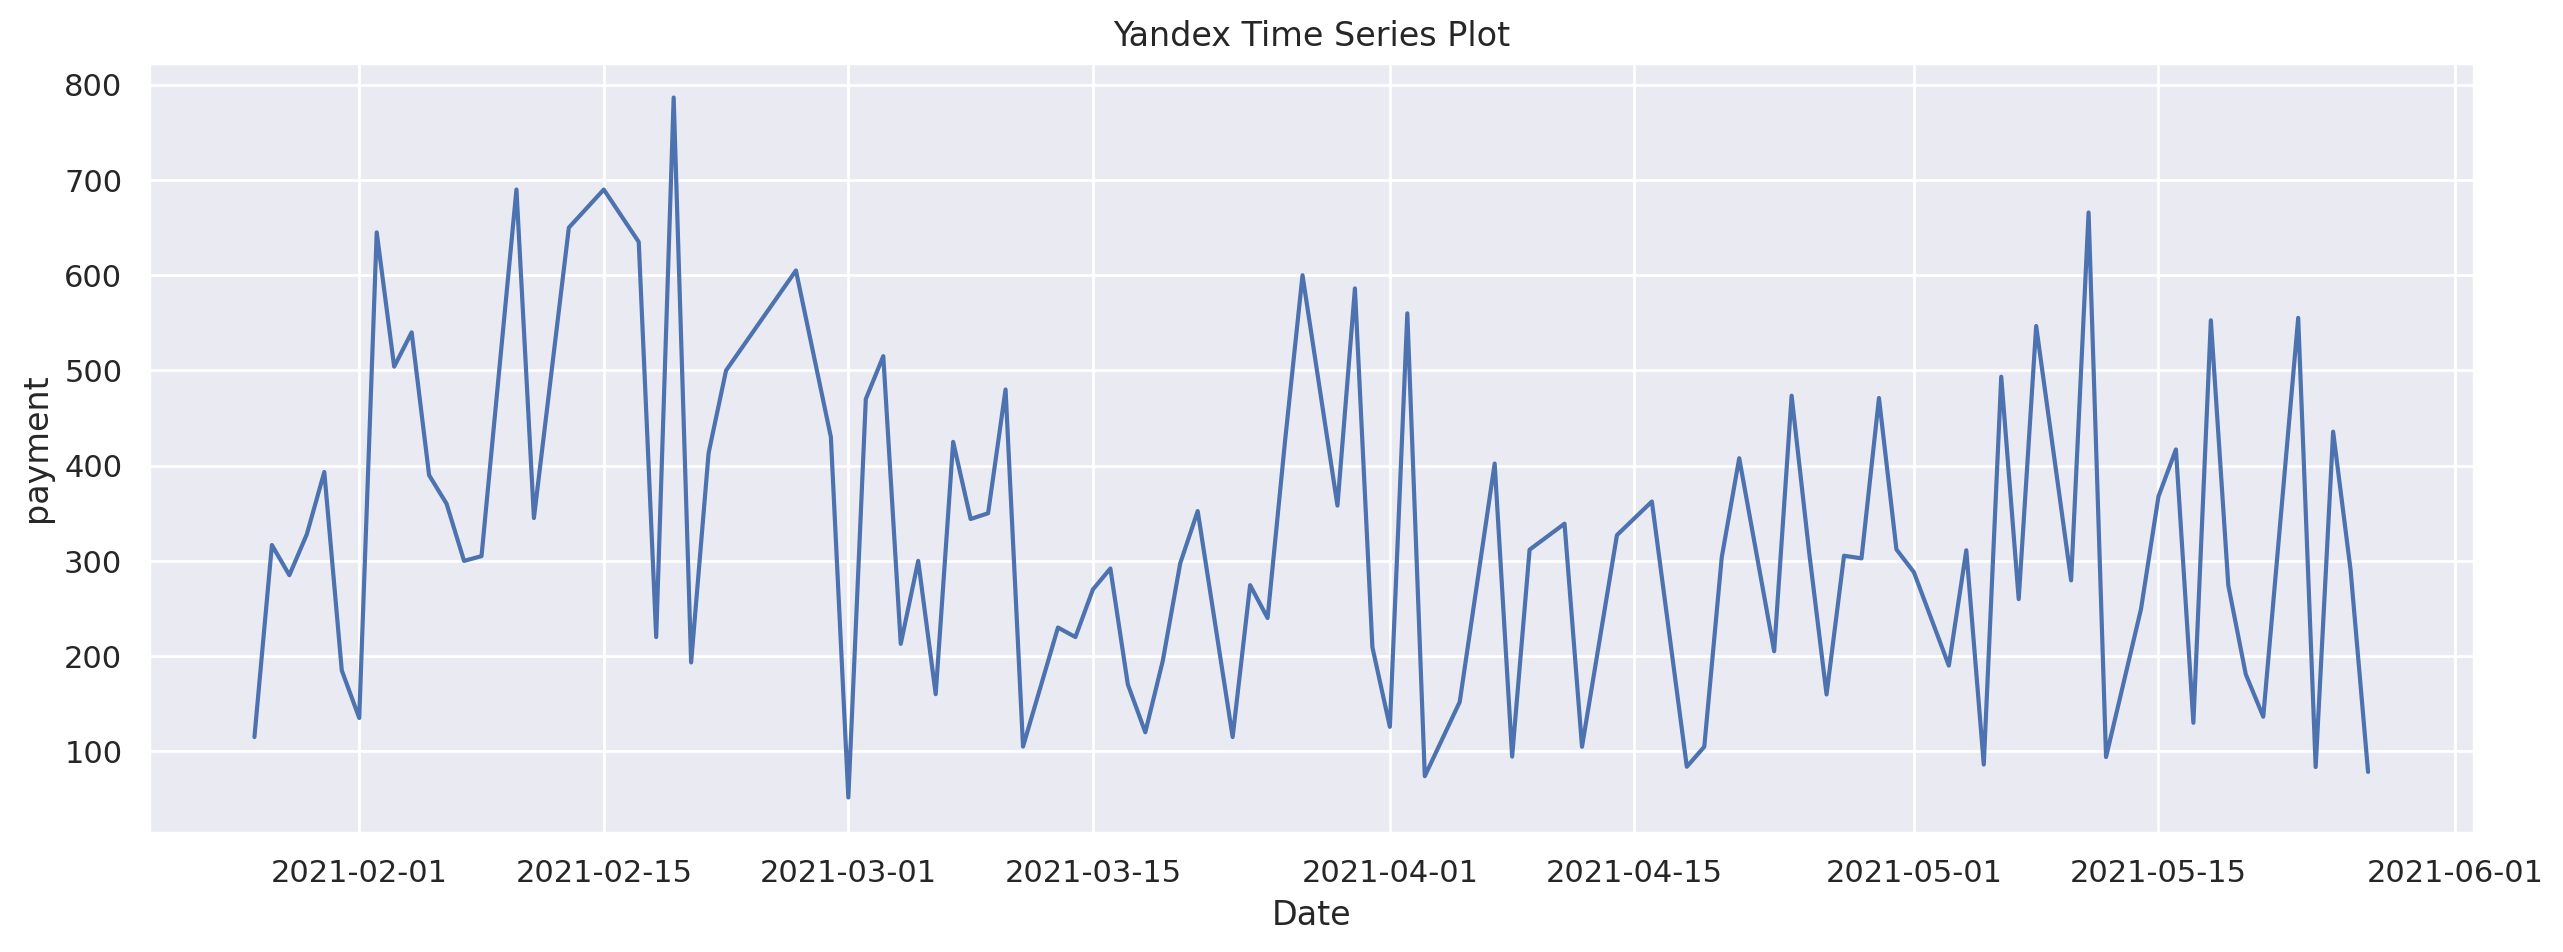

In [40]:
plt.figure(figsize=(10, 6))  # Set figure size

# Plot the time series
plt.figure(figsize=(15, 5))
plt.plot(df['payment_cost'], linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('payment')
plt.title('Yandex Time Series Plot')
# Show plot
plt.show()


In [41]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")


        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:],  alpha=0.4,label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

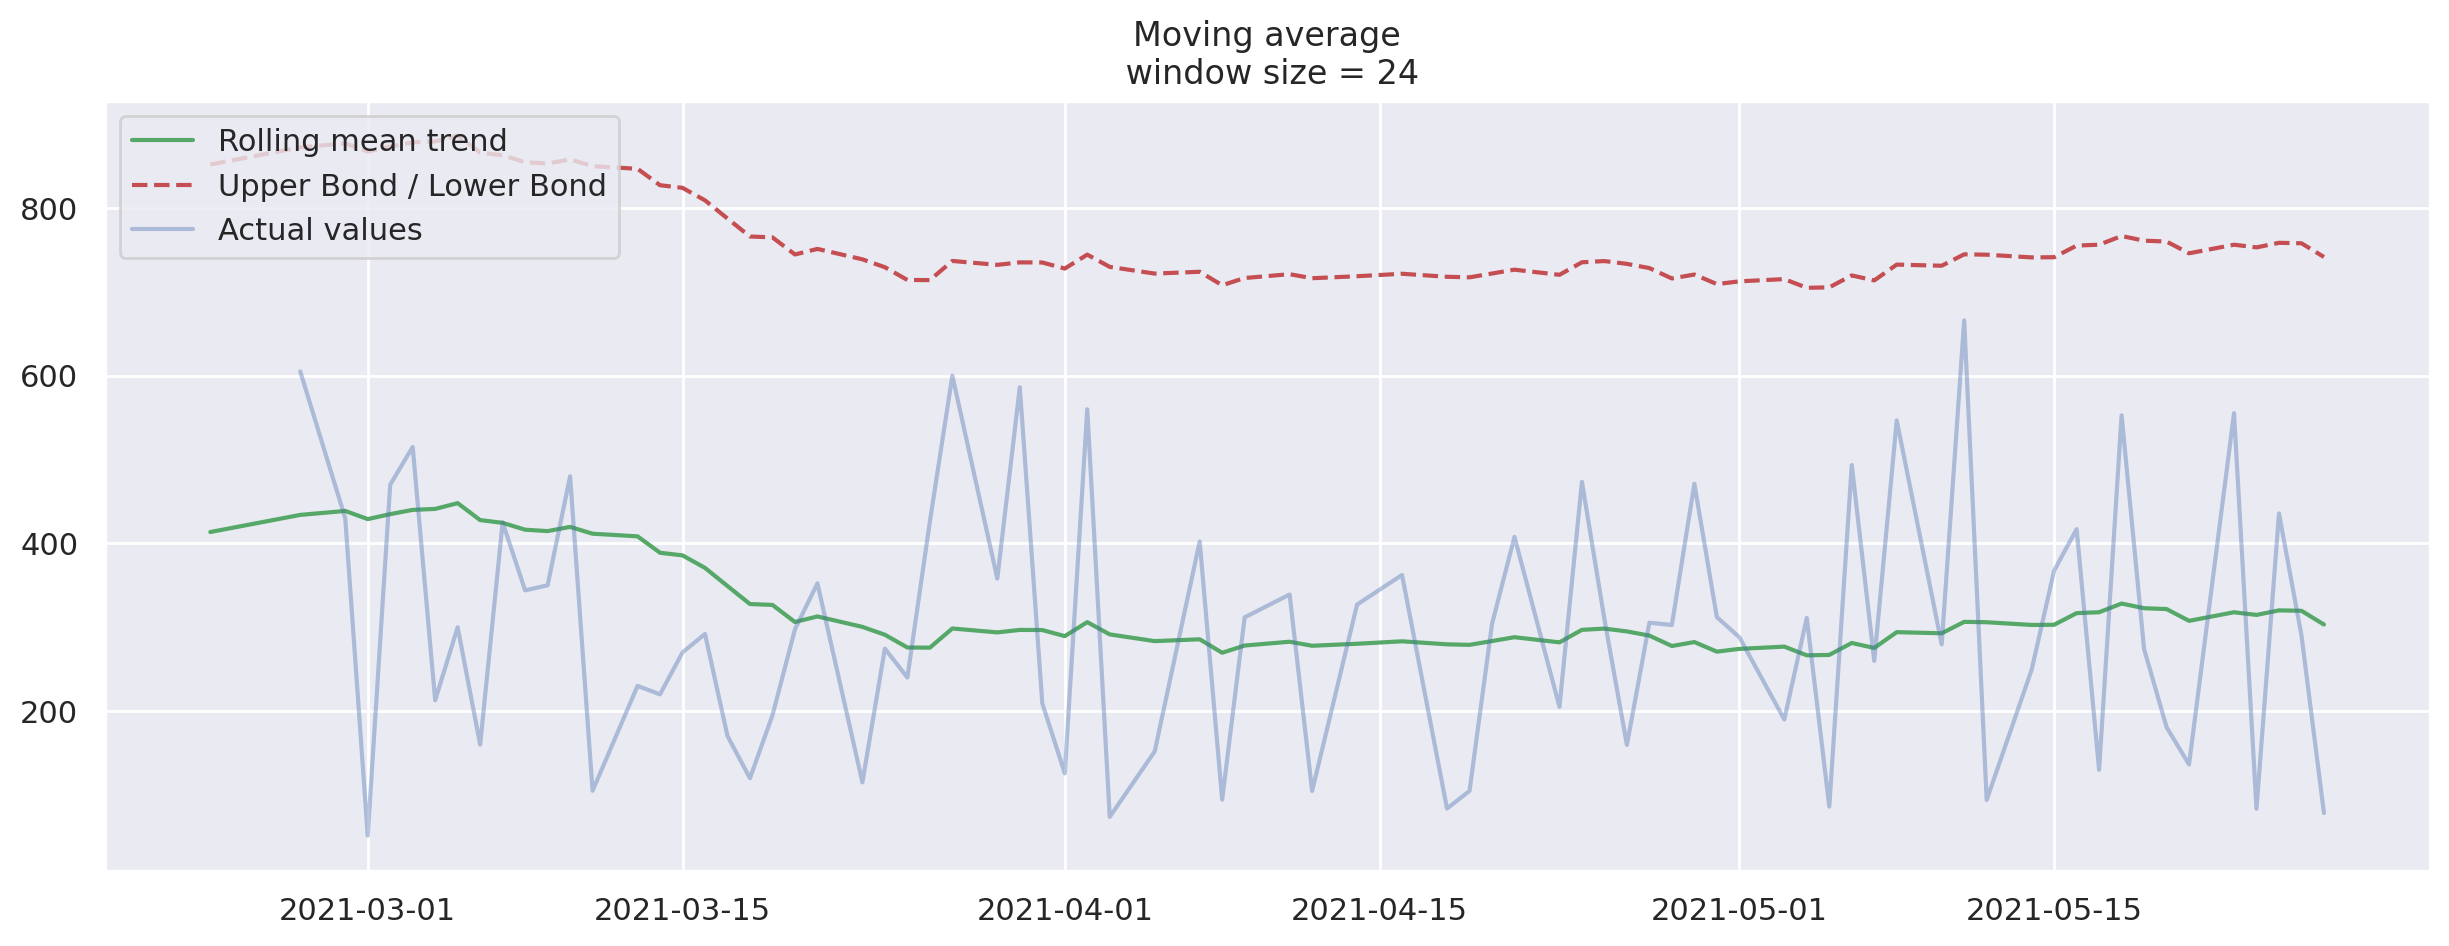

In [42]:
plotMovingAverage(df, 24, plot_intervals=True, plot_anomalies=True)

In [43]:
def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        ts_ax.plot(y)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(
            "Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value)
        )
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

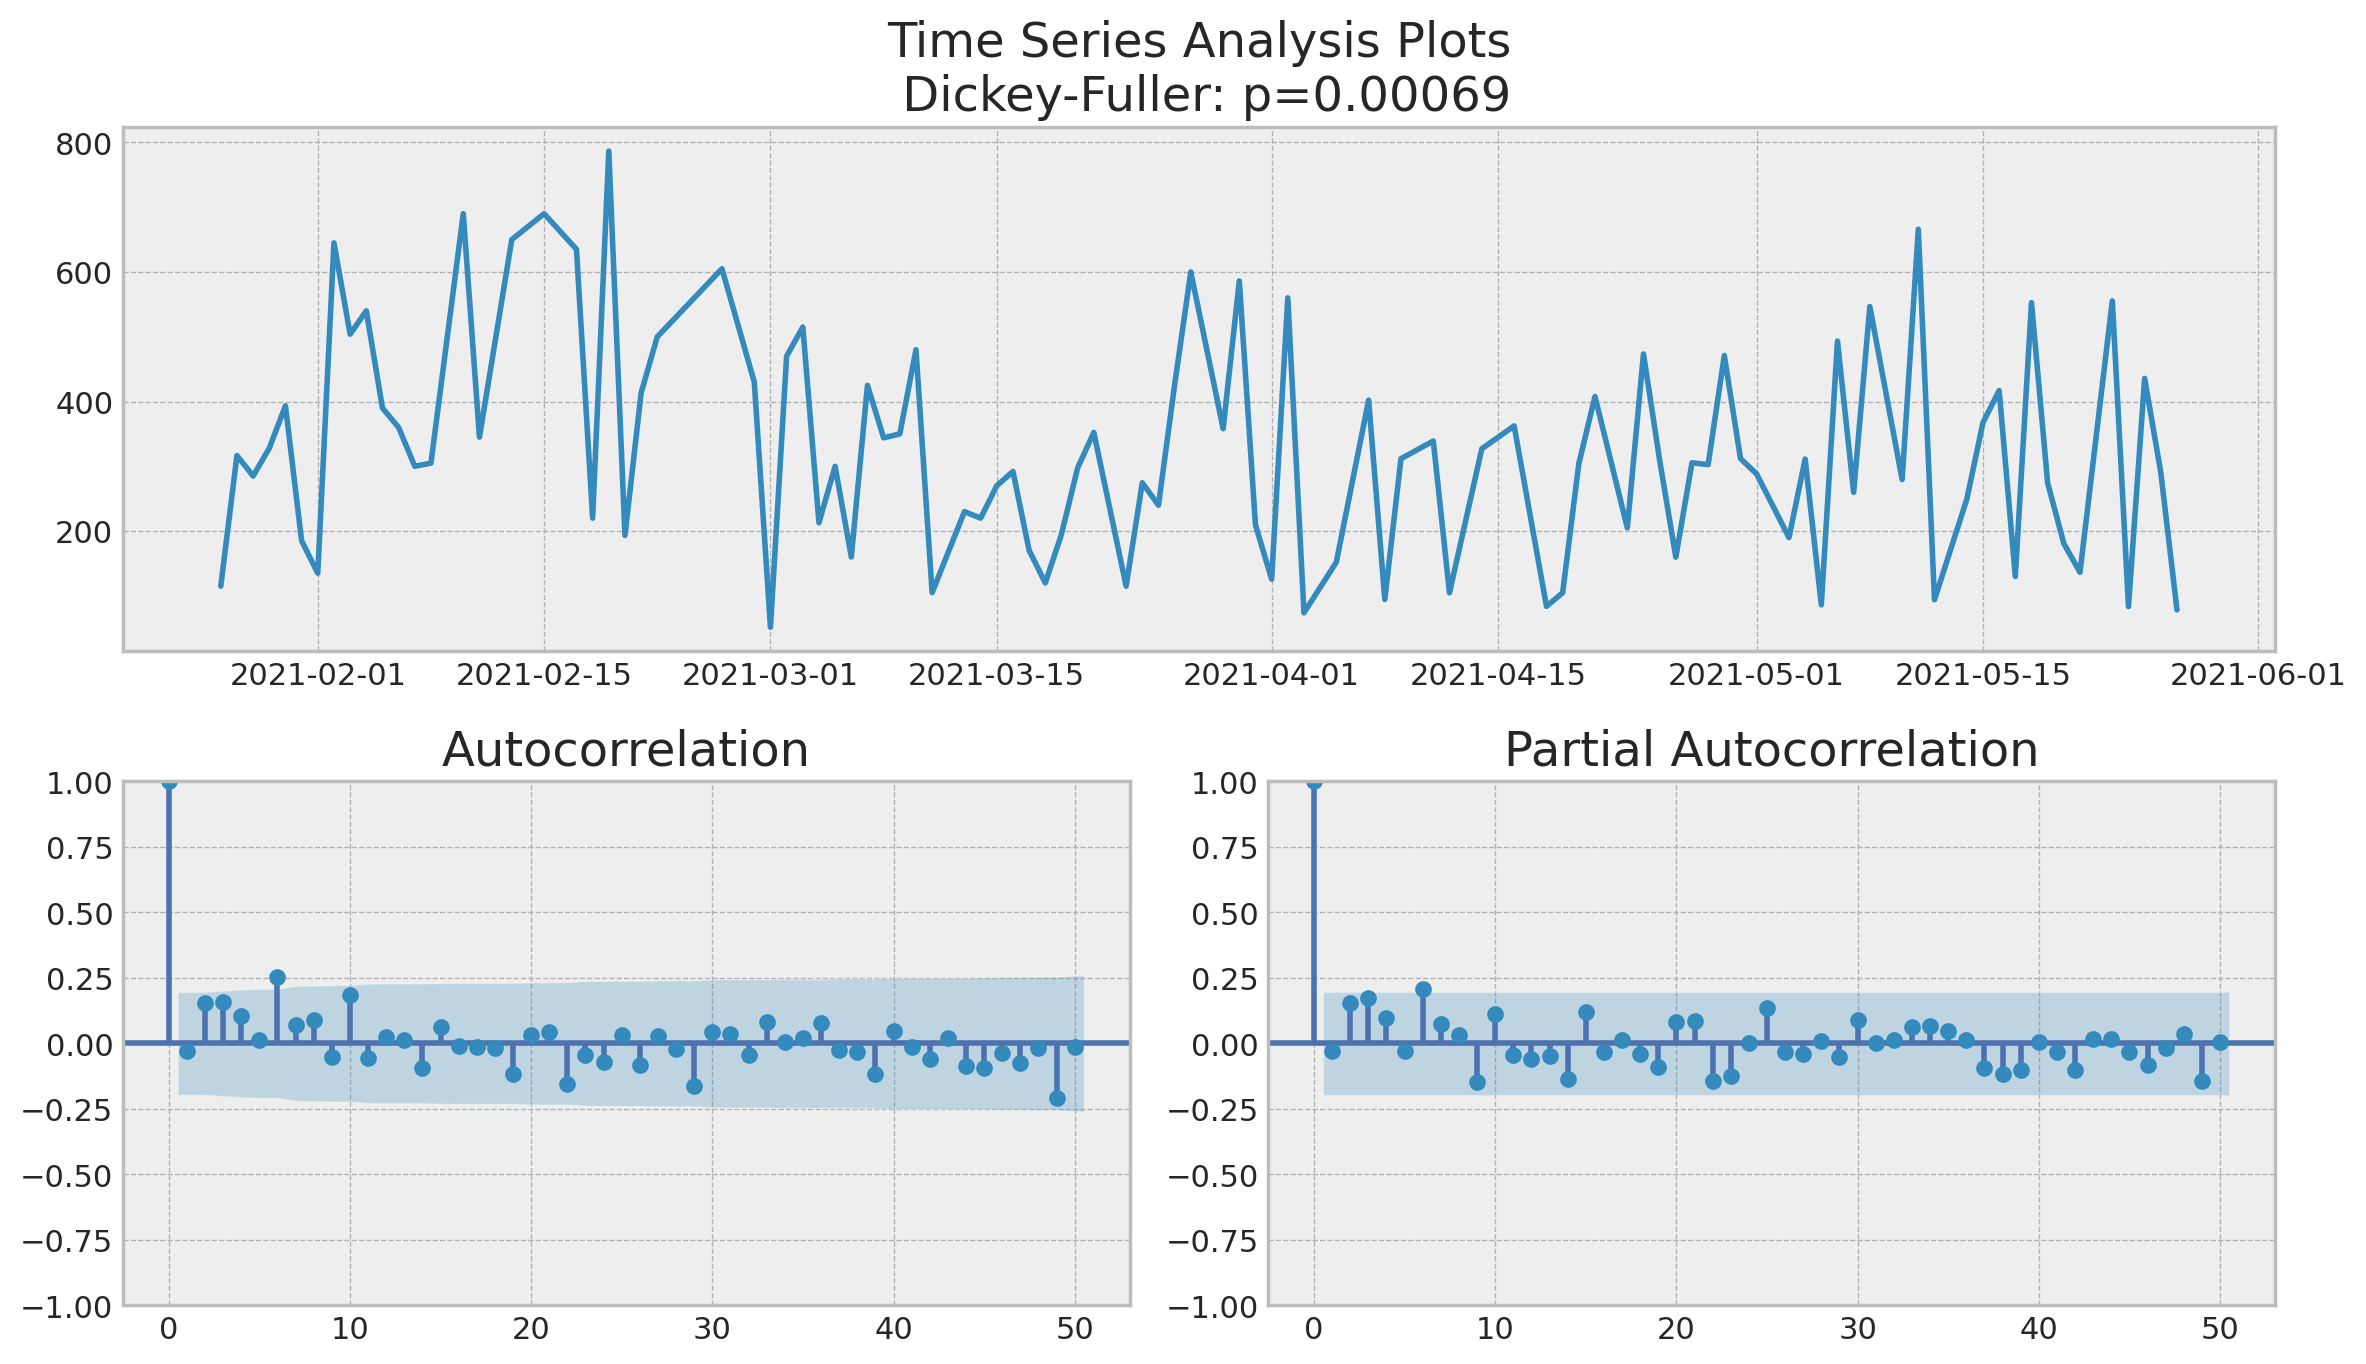

In [44]:
tsplot(df.payment_cost, lags=50)

In [10]:
df = df.tail(117)
df

,payment_cost
created_at_utc,
2021-01-01,680.000000
2021-01-02,294.000000
2021-01-03,175.000000
2021-01-05,170.000000
2021-01-06,790.000000
...,...
2021-05-23,555.225000
2021-05-24,83.525000
2021-05-25,435.683333


In [13]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'date' column is already in datetime format
# Assuming 'value' column is the one you want to forecast
# Replace 'value' with your actual column name if different


# Fit ARIMA model
model = ARIMA(df['payment_cost'], order=(1, 1, 1))  # Replace p, d, q with appropriate values
fit_model = model.fit()

# Forecast 2 months ahead
forecast = fit_model.forecast(steps=2)

# Print the forecast
print("Forecast for the next 2 months:")
print(forecast)


Forecast for the next 2 months:
117    284.418945
118    293.086718
Name: predicted_mean, dtype: float64


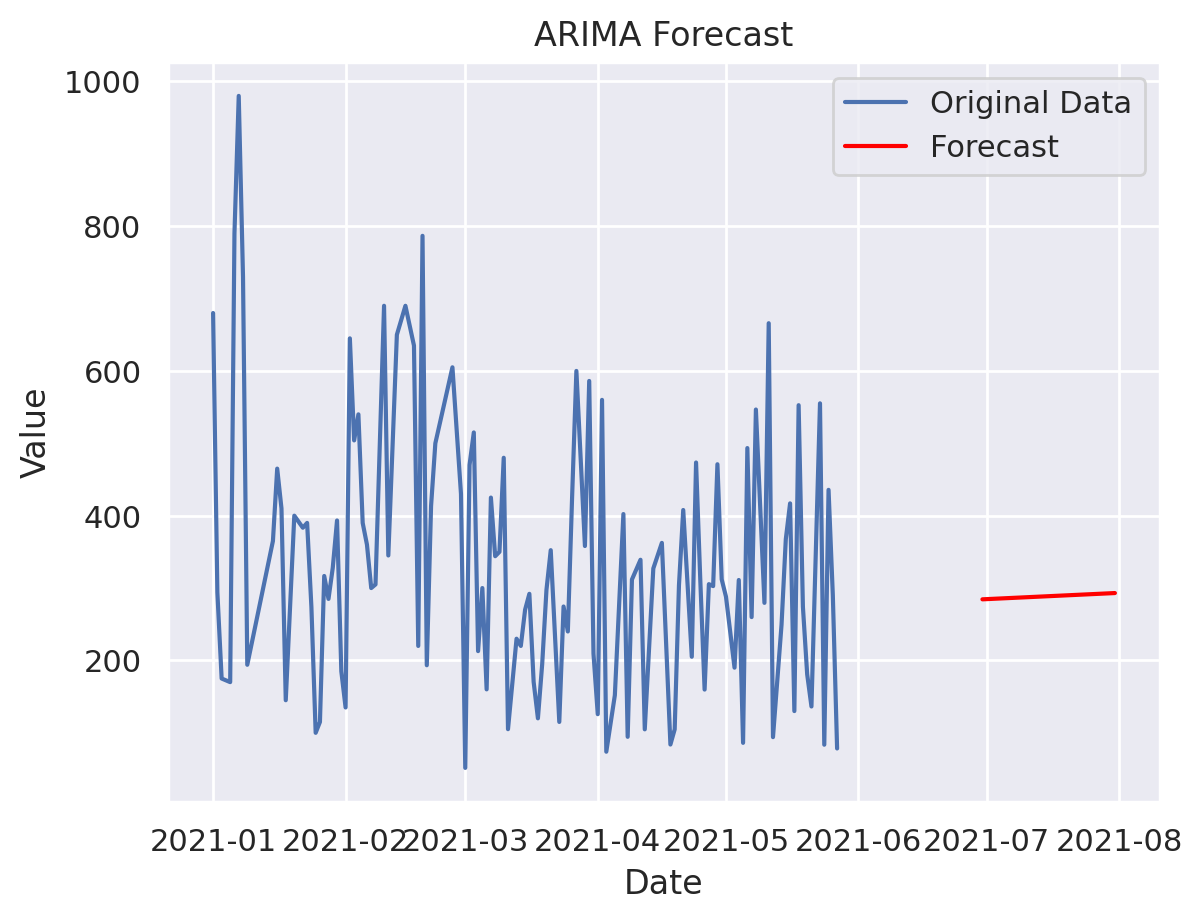

In [15]:
import matplotlib.pyplot as plt

# Plot original data
plt.plot(df.index, df['payment_cost'], label='Original Data')

# Plot forecasted values
forecast_index = pd.date_range(start=df.index[-1], periods=3, freq='M')[1:]  # Generating dates for forecast
plt.plot(forecast_index, forecast, label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()


In [17]:
forecast_index

DatetimeIndex(['2021-06-30', '2021-07-31'], dtype='datetime64[ns]', freq='ME')

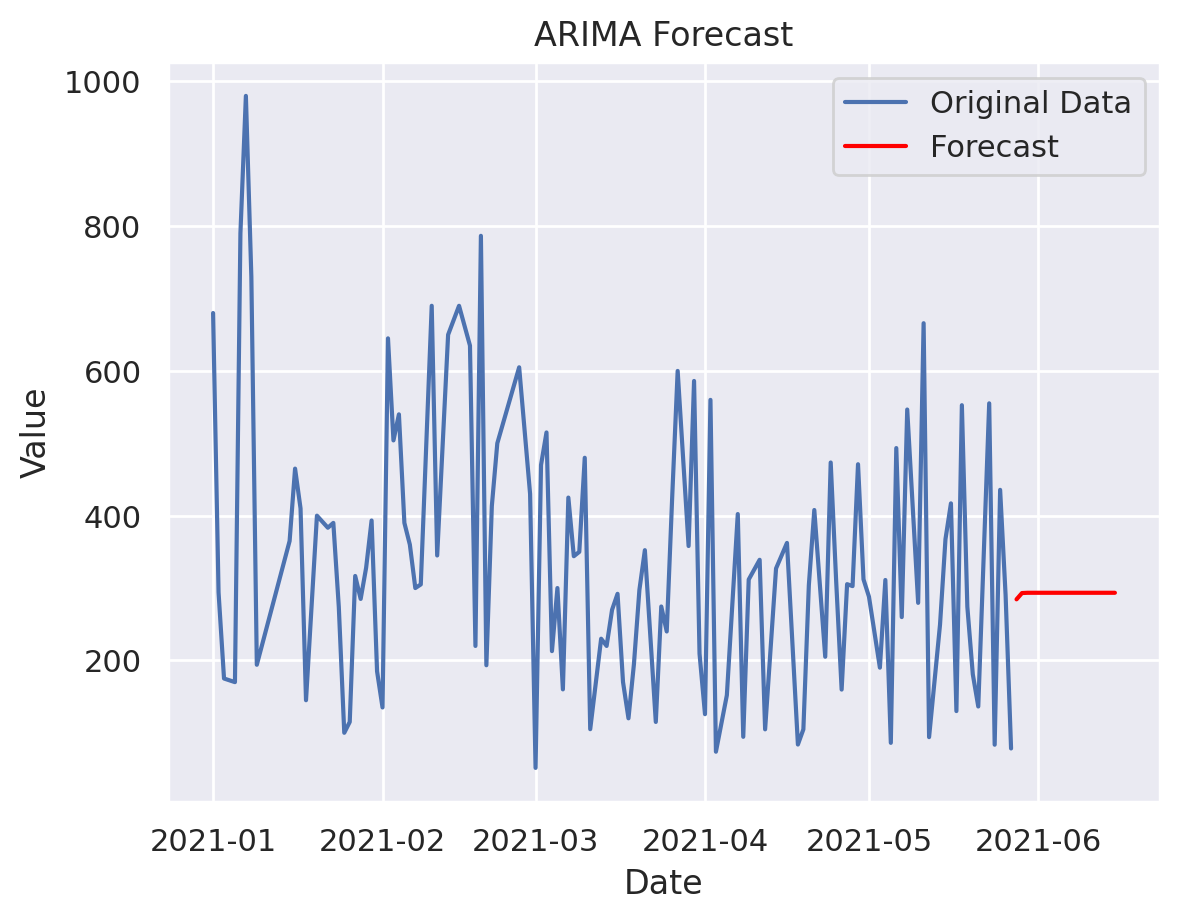

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'date' column is already in datetime format
# Assuming 'value' column is the one you want to forecast
# Replace 'value' with your actual column name if different


# Fit ARIMA model
model = ARIMA(df['payment_cost'], order=(1, 1, 1))  # Replace p, d, q with appropriate values
fit_model = model.fit()

# Define the frequency for forecasting
freq = 'D'  # Daily frequency
# freq = 'W'  # Weekly frequency
# freq = 'M'  # Monthly frequency

# Forecast with the specified frequency
forecast_index = pd.date_range(start=df.index[-1], periods=20, freq=freq)[1:]  # Generate dates for forecast

# Forecast
forecast = fit_model.forecast(steps=len(forecast_index))

# Plot original data
plt.plot(df.index, df['payment_cost'], label='Original Data')

# Plot forecasted values
plt.plot(forecast_index, forecast, label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()


In [23]:
forecast

117    284.418945
118    293.086718
119    293.451306
120    293.466641
121    293.467286
122    293.467313
123    293.467314
124    293.467314
125    293.467314
126    293.467314
127    293.467314
128    293.467314
129    293.467314
130    293.467314
131    293.467314
132    293.467314
133    293.467314
134    293.467314
135    293.467314
Name: predicted_mean, dtype: float64